In [1]:
%reload_ext autoreload
%autoreload 2
import sinter
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

from qecdec import RotatedSurfaceCode_Memory
from qecdec import BPDecoder, DMemBPDecoder, DMemOffNormBPDecoder, MWPMDecoder, SinterDecoderWrapper
from qecdec.utils import get_stats, bar_plot_stats, stacked_bar_plot_stats

# Learned gamma

In [2]:
d = 5
rounds = 5
error_rates = [0.004, 0.006, 0.008, 0.01, 0.012]
timestamp = "2025-09-21-20-21-45"

gamma = np.load(f"learned_params/dmembp_{timestamp}_gamma.npy")

In [3]:
def generate_sinter_tasks_and_custom_decoders():
    tasks: list[sinter.Task] = []
    custom_decoders: dict[str, sinter.Decoder] = {}
    for p in error_rates:
        # Setup the experiment.
        expmt = RotatedSurfaceCode_Memory(
            d=d,
            rounds=rounds,
            basis='Z',
            data_qubit_error_rate=p,
            meas_error_rate=p,
        )

        # Setup a sinter.Task with MWPM decoder.
        tasks.append(sinter.Task(
            circuit=expmt.circuit,
            detector_error_model=expmt.dem,
            decoder='pymatching',
            json_metadata={'p': p, 'decoder': 'pymatching'},
        ))

        # Setup a sinter.Task with BP decoder.
        bp = BPDecoder(expmt.chkmat, expmt.prior, max_iter=50)
        custom_decoder_id = f"custom_decoder_{len(custom_decoders)}"
        custom_decoders[custom_decoder_id] = SinterDecoderWrapper(bp, expmt.obsmat)
        tasks.append(sinter.Task(
            circuit=expmt.circuit,
            detector_error_model=expmt.dem,
            decoder=custom_decoder_id,
            json_metadata={'p': p, 'decoder': 'bp'},
        ))

        # Setup a sinter.Task with DMemBP decoder.
        dmembp = DMemBPDecoder(expmt.chkmat, expmt.prior, gamma=gamma, max_iter=50)
        custom_decoder_id = f"custom_decoder_{len(custom_decoders)}"
        custom_decoders[custom_decoder_id] = SinterDecoderWrapper(dmembp, expmt.obsmat)
        tasks.append(sinter.Task(
            circuit=expmt.circuit,
            detector_error_model=expmt.dem,
            decoder=custom_decoder_id,
            json_metadata={'p': p, 'decoder': 'dmembp'},
        ))
    return tasks, custom_decoders

tasks, custom_decoders = generate_sinter_tasks_and_custom_decoders()

In [4]:
sinter_stats = sinter.collect(
    num_workers=os.cpu_count() - 1,
    max_shots=10_000_000,
    max_errors=100,
    tasks=tasks,
    custom_decoders=custom_decoders,
    print_progress=True,
)

Starting 7 workers...


15 tasks left:
  workers          decoder eta shots_left errors_left json_metadata             
        1       pymatching   ?   10000000         100 p=0.004,decoder=pymatching
        1 custom_decoder_0   ?   10000000         100 p=0.004,decoder=bp        
        1 custom_decoder_1  1m    9997679         100 p=0.004,decoder=dmembp    
        1       pymatching   ?   10000000         100 p=0.006,decoder=pymatching
        1 custom_decoder_2   ?   10000000         100 p=0.006,decoder=bp        
        1 custom_decoder_3   ?   10000000         100 p=0.006,decoder=dmembp    
        1       pymatching   ?   10000000         100 p=0.008,decoder=pymatching
        0 custom_decoder_4 ?·∞   10000000         100 p=0.008,decoder=bp        
        0 custom_decoder_5 ?·∞   10000000         100 p=0.008,decoder=dmembp    
        0       pymatching ?·∞   10000000         100 p=0.01,decoder=pymatching 
        0 custom_decoder_6 ?·∞   10000000         100 p=0.01,decoder=bp         
        0 cus

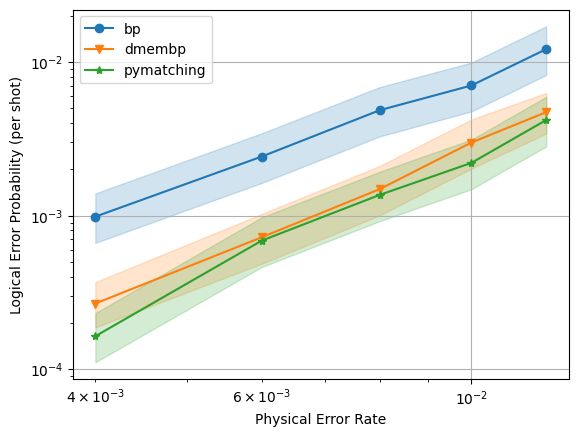

In [5]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=sinter_stats,
    group_func=lambda stat: f"{stat.json_metadata['decoder']}",
    x_func=lambda stat: stat.json_metadata['p'],
)
ax.loglog()
ax.grid()
ax.set_ylabel('Logical Error Probability (per shot)')
ax.set_xlabel('Physical Error Rate')
ax.legend()

In [6]:
seed = 42
shots = 10_000
bp_iters = 50

results = {}

for p in error_rates:
    category = 'p={:.3f}'.format(p)
    print("Collecting data for {}".format(category))

    # Set up the experiment.
    expmt = RotatedSurfaceCode_Memory(
        d, rounds,
        basis='Z',
        data_qubit_error_rate=p,
        meas_error_rate=p,
    )

    # Sample data.
    sampler = expmt.circuit.compile_detector_sampler(seed=seed)
    syndromes, observables = sampler.sample(shots, separate_observables=True)

    # Set up the decoders.
    bp = BPDecoder(expmt.chkmat, expmt.prior, max_iter=bp_iters)
    dmembp = DMemBPDecoder(expmt.chkmat, expmt.prior, gamma=gamma, max_iter=bp_iters)
    mwpm = MWPMDecoder(expmt.chkmat, expmt.prior)

    # Decode.
    print("Decoding with BP...")
    ehat_bp = bp.decode_batch(syndromes)
    print("Decoding with DMemBP...")
    ehat_dmembp = dmembp.decode_batch(syndromes)
    print("Decoding with MWPM...")
    ehat_mwpm = mwpm.decode_batch(syndromes)

    # Get stats and store results.
    print("Getting stats...")
    results[category] = {
        'BP': get_stats(expmt.chkmat, expmt.obsmat, syndromes, observables, ehat_bp),
        'DMemBP': get_stats(expmt.chkmat, expmt.obsmat, syndromes, observables, ehat_dmembp),
        'MWPM': get_stats(expmt.chkmat, expmt.obsmat, syndromes, observables, ehat_mwpm),
    }
    print("-" * 100)

print("Data collection complete!")

Decoding with BP...
Decoding with DMemBP...
Decoding with MWPM...
Getting stats...
----------------------------------------------------------------------------------------------------
Decoding with BP...
Decoding with DMemBP...
Decoding with MWPM...
Getting stats...
----------------------------------------------------------------------------------------------------
Decoding with BP...
Decoding with DMemBP...
Decoding with MWPM...
Getting stats...
----------------------------------------------------------------------------------------------------
Decoding with BP...
Decoding with DMemBP...
Decoding with MWPM...
Getting stats...
----------------------------------------------------------------------------------------------------
Decoding with BP...
Decoding with DMemBP...
Decoding with MWPM...
Getting stats...
----------------------------------------------------------------------------------------------------
Data collection complete!


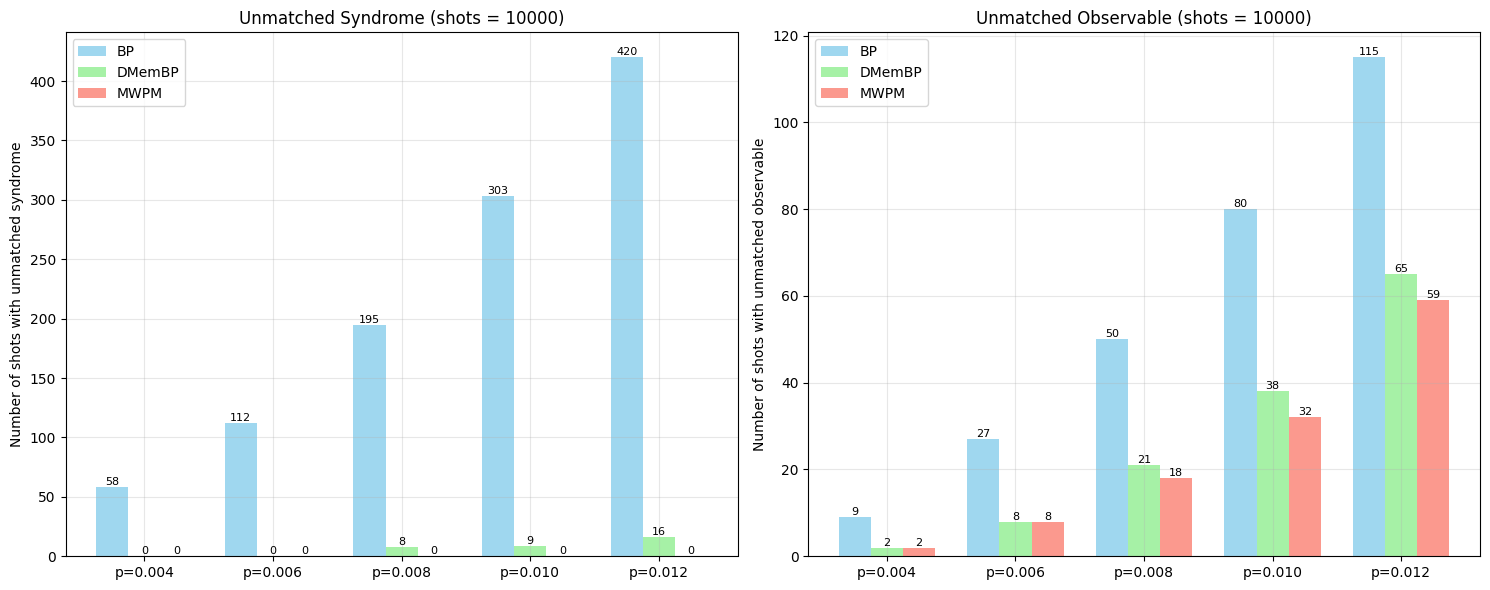

In [7]:
bar_plot_stats(results)

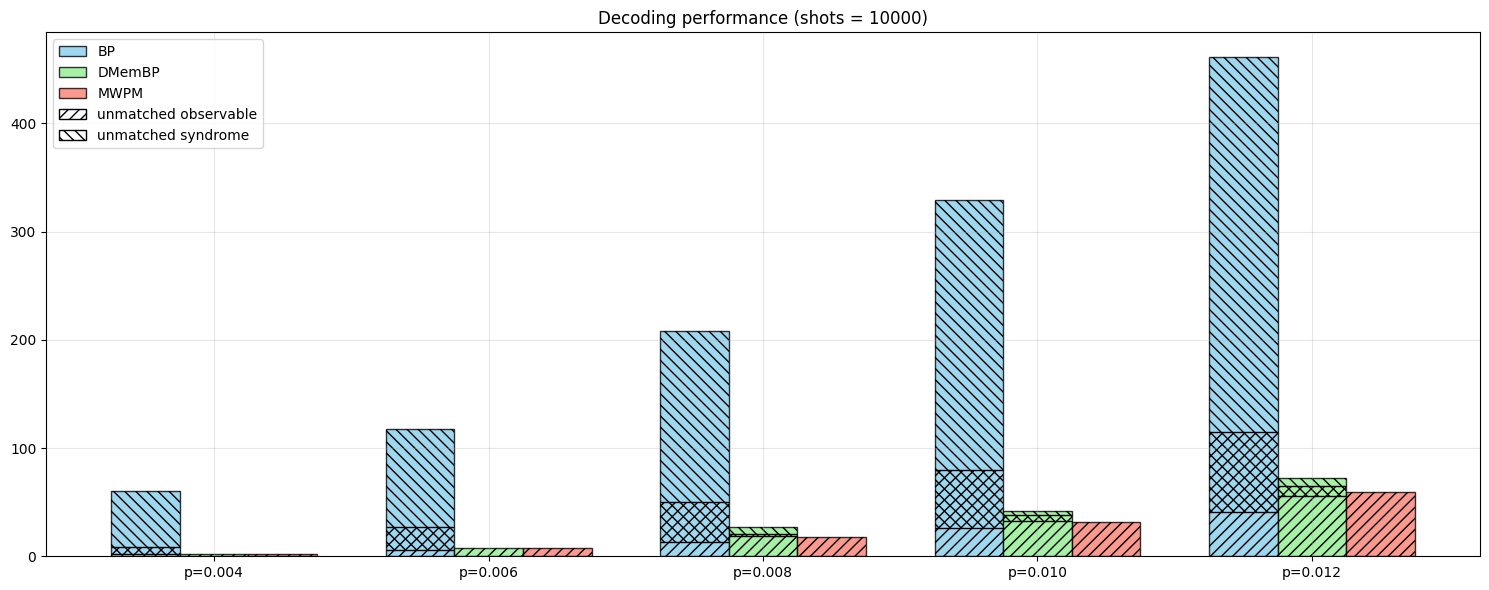

In [8]:
stacked_bar_plot_stats(results)

# Learned gamma + normalization factors

In [10]:
d = 5
rounds = 5
error_rates = [0.004, 0.006, 0.008, 0.01, 0.012]
timestamp = "2025-09-23-18-07-24"

gamma = np.load(f"learned_params/dmemoffnormbp_{timestamp}_gamma.npy")
with open(f"learned_params/dmemoffnormbp_{timestamp}_nf.pkl", "rb") as f:
    nf = pickle.load(f)

In [11]:
def generate_sinter_tasks_and_custom_decoders():
    tasks: list[sinter.Task] = []
    custom_decoders: dict[str, sinter.Decoder] = {}
    for p in error_rates:
        # Setup the experiment.
        expmt = RotatedSurfaceCode_Memory(
            d=d,
            rounds=rounds,
            basis='Z',
            data_qubit_error_rate=p,
            meas_error_rate=p,
        )

        # Setup a sinter.Task with MWPM decoder.
        tasks.append(sinter.Task(
            circuit=expmt.circuit,
            detector_error_model=expmt.dem,
            decoder='pymatching',
            json_metadata={'p': p, 'decoder': 'pymatching'},
        ))

        # Setup a sinter.Task with BP decoder.
        bp = BPDecoder(expmt.chkmat, expmt.prior, max_iter=50)
        custom_decoder_id = f"custom_decoder_{len(custom_decoders)}"
        custom_decoders[custom_decoder_id] = SinterDecoderWrapper(bp, expmt.obsmat)
        tasks.append(sinter.Task(
            circuit=expmt.circuit,
            detector_error_model=expmt.dem,
            decoder=custom_decoder_id,
            json_metadata={'p': p, 'decoder': 'bp'},
        ))

        # Setup a sinter.Task with DMemOffNormBP decoder.
        dmemoffnormbp = DMemOffNormBPDecoder(expmt.chkmat, expmt.prior, gamma=gamma, nf=nf, max_iter=50)
        custom_decoder_id = f"custom_decoder_{len(custom_decoders)}"
        custom_decoders[custom_decoder_id] = SinterDecoderWrapper(dmemoffnormbp, expmt.obsmat)
        tasks.append(sinter.Task(
            circuit=expmt.circuit,
            detector_error_model=expmt.dem,
            decoder=custom_decoder_id,
            json_metadata={'p': p, 'decoder': 'learned_bp'},
        ))
    return tasks, custom_decoders

tasks, custom_decoders = generate_sinter_tasks_and_custom_decoders()

In [12]:
sinter_stats = sinter.collect(
    num_workers=os.cpu_count() - 1,
    max_shots=10_000_000,
    max_errors=100,
    tasks=tasks,
    custom_decoders=custom_decoders,
    print_progress=True,
)

Starting 7 workers...
15 tasks left:
  workers          decoder eta shots_left errors_left json_metadata             
        1       pymatching   ?   10000000         100 p=0.004,decoder=pymatching
        1 custom_decoder_0   ?   10000000         100 p=0.004,decoder=bp        
        1 custom_decoder_1   ?   10000000         100 p=0.004,decoder=learned_bp
        1       pymatching   ?   10000000         100 p=0.006,decoder=pymatching
        1 custom_decoder_2   ?   10000000         100 p=0.006,decoder=bp        
        1 custom_decoder_3 <1m    9997679          99 p=0.006,decoder=learned_bp
        1       pymatching   ?   10000000         100 p=0.008,decoder=pymatching
        0 custom_decoder_4 ?·∞   10000000         100 p=0.008,decoder=bp        
        0 custom_decoder_5 ?·∞   10000000         100 p=0.008,decoder=learned_bp
        0       pymatching ?·∞   10000000         100 p=0.01,decoder=pymatching 
        0 custom_decoder_6 ?·∞   10000000         100 p=0.01,decoder=bp 

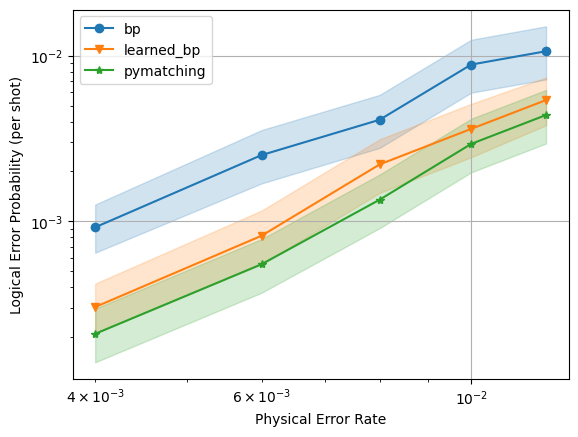

In [13]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=sinter_stats,
    group_func=lambda stat: f"{stat.json_metadata['decoder']}",
    x_func=lambda stat: stat.json_metadata['p'],
)
ax.loglog()
ax.grid()
ax.set_ylabel('Logical Error Probability (per shot)')
ax.set_xlabel('Physical Error Rate')
ax.legend()

In [14]:
seed = 42
shots = 10_000
bp_iters = 50

results = {}

for p in error_rates:
    category = 'p={:.3f}'.format(p)
    print("Collecting data for {}".format(category))

    # Set up the experiment.
    expmt = RotatedSurfaceCode_Memory(
        d, rounds,
        basis='Z',
        data_qubit_error_rate=p,
        meas_error_rate=p,
    )

    # Sample data.
    sampler = expmt.circuit.compile_detector_sampler(seed=seed)
    syndromes, observables = sampler.sample(shots, separate_observables=True)

    # Set up the decoders.
    bp = BPDecoder(expmt.chkmat, expmt.prior, max_iter=bp_iters)
    dmemoffnormbp = DMemOffNormBPDecoder(expmt.chkmat, expmt.prior, gamma=gamma, nf=nf, max_iter=bp_iters)
    mwpm = MWPMDecoder(expmt.chkmat, expmt.prior)

    # Decode.
    print("Decoding with BP...")
    ehat_bp = bp.decode_batch(syndromes)
    print("Decoding with learned BP...")
    ehat_dmemoffnormbp = dmemoffnormbp.decode_batch(syndromes)
    print("Decoding with MWPM...")
    ehat_mwpm = mwpm.decode_batch(syndromes)

    # Get stats and store results.
    print("Getting stats...")
    results[category] = {
        'BP': get_stats(expmt.chkmat, expmt.obsmat, syndromes, observables, ehat_bp),
        'learned BP': get_stats(expmt.chkmat, expmt.obsmat, syndromes, observables, ehat_dmemoffnormbp),
        'MWPM': get_stats(expmt.chkmat, expmt.obsmat, syndromes, observables, ehat_mwpm),
    }
    print("-" * 100)

print("Data collection complete!")

Decoding with BP...
Decoding with learned BP...
Decoding with MWPM...
Getting stats...
----------------------------------------------------------------------------------------------------
Decoding with BP...
Decoding with learned BP...
Decoding with MWPM...
Getting stats...
----------------------------------------------------------------------------------------------------
Decoding with BP...
Decoding with learned BP...
Decoding with MWPM...
Getting stats...
----------------------------------------------------------------------------------------------------
Decoding with BP...
Decoding with learned BP...
Decoding with MWPM...
Getting stats...
----------------------------------------------------------------------------------------------------
Decoding with BP...
Decoding with learned BP...
Decoding with MWPM...
Getting stats...
----------------------------------------------------------------------------------------------------
Data collection complete!


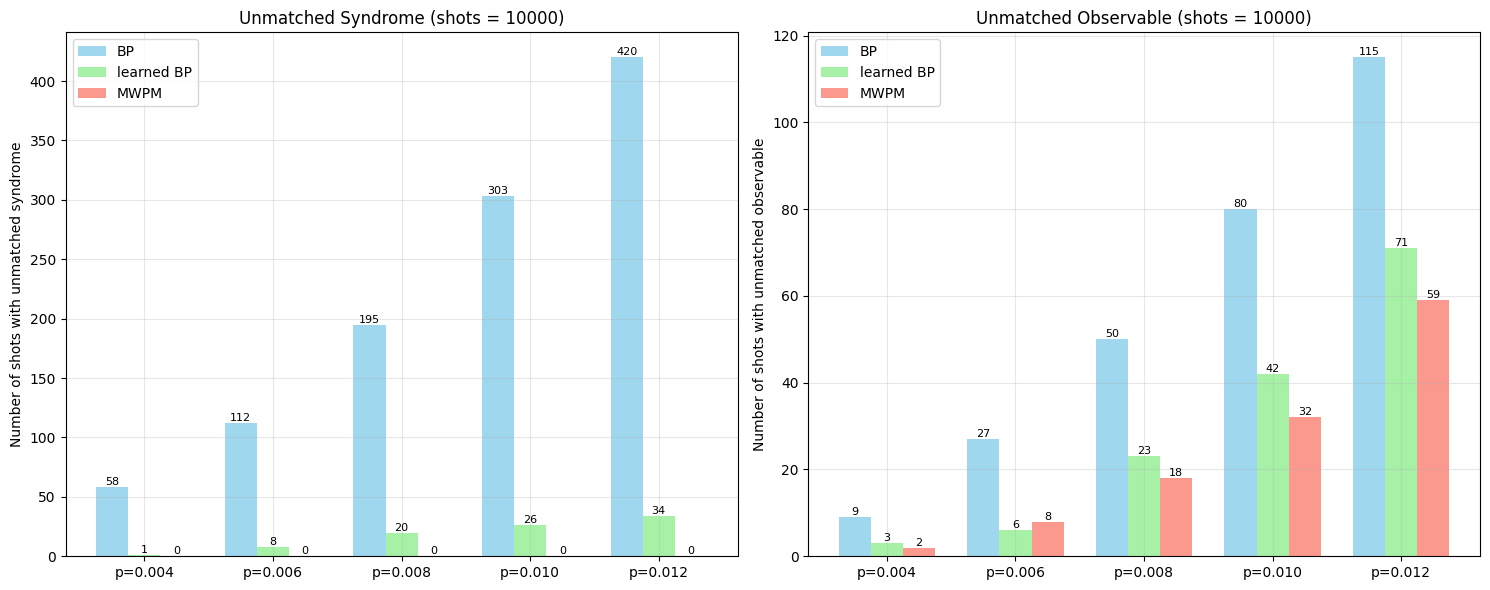

In [15]:
bar_plot_stats(results)

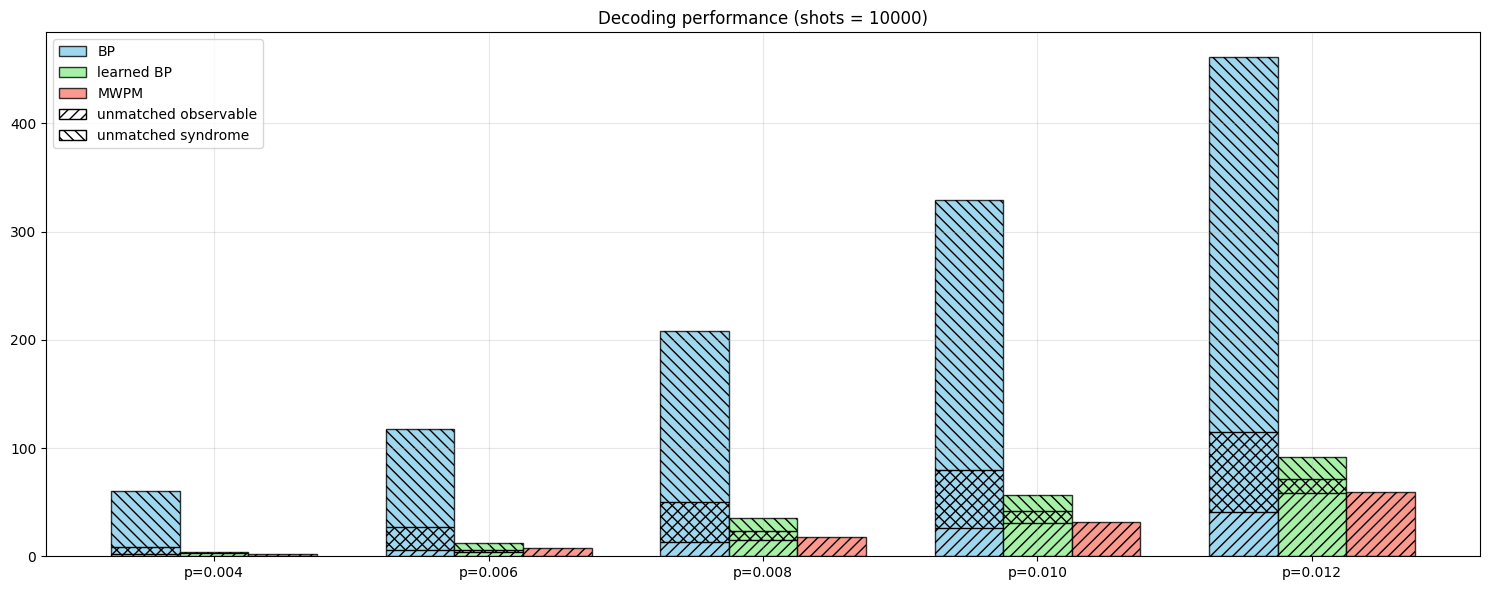

In [16]:
stacked_bar_plot_stats(results)